<a href="https://colab.research.google.com/github/TheReallyBigApple/CunyAssignments/blob/main/Data604/chap08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#                       CUNY MSDS Data604 Week 4
#                            Tom Buonora

# Chapter 8

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [ ]:
# check if the libraries we need are installed

try:
    import pint
except ImportError:
    !pip install pint
    import pint
    
try:
    from modsim import *
except ImportError:
    !pip install modsimpy
    from modsim import *

In [ ]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# import functions from the modsim.py module
from modsim import *

### Functions from the previous chapter

In [ ]:
def plot_results(census, un, timeseries, title):
    """Plot the estimates and the model.
    
    census: TimeSeries of population estimates
    un: TimeSeries of population estimates
    timeseries: TimeSeries of simulation results
    title: string
    """
    plot(census, ':', label='US Census')
    plot(un, '--', label='UN DESA')
    plot(timeseries, color='gray', label='model')
    
    decorate(xlabel='Year', 
             ylabel='World population (billion)',
             title=title)

In [ ]:
def run_simulation(system, update_func):
    """Simulate the system using any update function.
    
    system: System object
    update_func: function that computes the population next year
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end):
        results[t+1] = update_func(results[t], t, system)
        
    return results

### Reading the data

In [ ]:
# Get the data file

import os

filename = 'World_population_estimates2.csv'
if not os.path.exists(filename):
    !wget https://raw.githubusercontent.com/AllenDowney/ModSimPy/master/data/World_population_estimates2.csv

In [ ]:
table2 = pd.read_csv('World_population_estimates2.csv')
table2.index = table2.Year
table2.head()

,Year,census,prb,un,maddison,hyde,tanton,biraben,mj,thomlinson,durand,clark
Year,,,,,,,,,,,,
1950,1950,2557628654,2.516000e+09,2.525149e+09,2.544000e+09,2.527960e+09,2.400000e+09,2.527000e+09,2.500000e+09,2.400000e+09,NaN,2.486000e+09
1951,1951,2594939877,NaN,2.572851e+09,2.571663e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1952,1952,2636772306,NaN,2.619292e+09,2.617949e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1953,1953,2682053389,NaN,2.665865e+09,2.665959e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1954,1954,2730228104,NaN,2.713172e+09,2.716927e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN


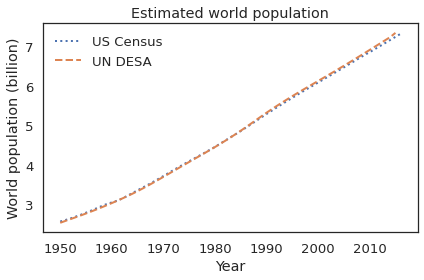

In [ ]:
un = table2.un / 1e9
census = table2.census / 1e9
plot(census, ':', label='US Census')
plot(un, '--', label='UN DESA')
    
decorate(xlabel='Year', 
             ylabel='World population (billion)',
             title='Estimated world population')

### Running the quadratic model

Here's the update function for the quadratic growth model with parameters `alpha` and `beta`.

In [ ]:
def update_func_quad(pop, t, system):
    """Update population based on a quadratic model.
    
    pop: current population in billions
    t: what year it is
    system: system object with model parameters
    """
    net_growth = system.alpha * pop + system.beta * pop**2
    return pop + net_growth

Extract the starting time and population.

In [ ]:
t_0 = get_first_label(census)
t_end = get_last_label(census)
p_0 = get_first_value(census)

Initialize the system object.

In [ ]:
system = System(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                alpha=0.025,
                beta=-0.0018)

Run the model and plot results.

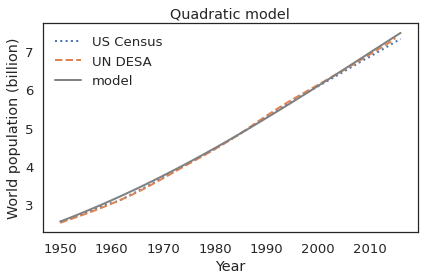

In [ ]:
results = run_simulation(system, update_func_quad)
plot_results(census, un, results, 'Quadratic model')

### Generating projections

To generate projections, all we have to do is change `t_end`

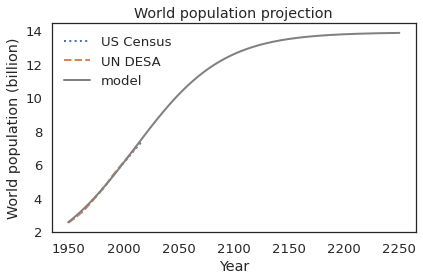

In [ ]:
system.t_end = 2250
results = run_simulation(system, update_func_quad)
plot_results(census, un, results, 'World population projection')

The population in the model converges on the equilibrium population, `-alpha/beta`

In [ ]:
results[system.t_end]

13.856665141368708

In [ ]:
-system.alpha / system.beta

13.88888888888889

**Exercise:**  What happens if we start with an initial population above the carrying capacity, like 20 billion?  Run the model with initial populations between 1 and 20 billion, and plot the results on the same axes.

<br><font color="purple">Past the carrying capacity it decreases but it remains in an equilibrium</font><br>

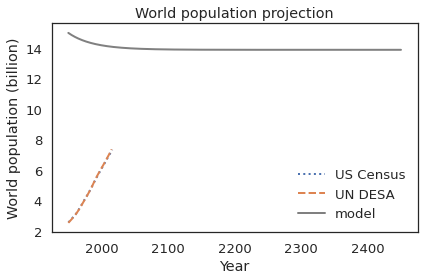

In [ ]:

system = System(t_0=t_0, t_end=2450, p_0=15, alpha=0.025,  beta=-0.0018)

results = run_simulation(system, update_func_quad)
plot_results(census, un, results, 'World population projection')

### Comparing projections

We can compare the projection from our model with projections produced by people who know what they are doing.

In [ ]:
# Get the data file

import os

filename = 'World_population_estimates3.csv'
if not os.path.exists(filename):
    !wget https://raw.githubusercontent.com/AllenDowney/ModSimPy/master/data/World_population_estimates3.csv


In [ ]:
def read_table3(filename = 'data/World_population_estimates.html'):
    tables = pd.read_html(filename, header=0, index_col=0, decimal='M')
    table3 = tables[3]
    table3.columns = ['census', 'prb', 'un']
    return table3

In [ ]:
#table3 = read_table3()
#table3.to_csv('data/World_population_estimates3.csv')

In [ ]:
table3 = pd.read_csv('World_population_estimates3.csv')
table3.index = table3.Year
table3.head()

,Year,census,prb,un
Year,,,,
2016,2016,7.334772e+09,NaN,7.432663e+09
2017,2017,7.412779e+09,NaN,NaN
2018,2018,7.490428e+09,NaN,NaN
2019,2019,7.567403e+09,NaN,NaN
2020,2020,7.643402e+09,NaN,7.758157e+09


`NaN` is a special value that represents missing data, in this case because some agencies did not publish projections for some years.

This function plots projections from the UN DESA and U.S. Census.  It uses `dropna` to remove the `NaN` values from each series before plotting it.

In [ ]:
def plot_projections(table):
    """Plot world population projections.
    
    table: DataFrame with columns 'un' and 'census'
    """
    census_proj = table.census / 1e9
    un_proj = table.un / 1e9
    
    plot(census_proj.dropna(), ':', color='C0', label='US Census')
    plot(un_proj.dropna(), '--', color='C1', label='UN DESA')

Run the model until 2100, which is as far as the other projections go.

In [ ]:
system = System(t_0=t_0, 
                t_end=2100,
                p_0=p_0,
                alpha=0.025,
                beta=-0.0018)

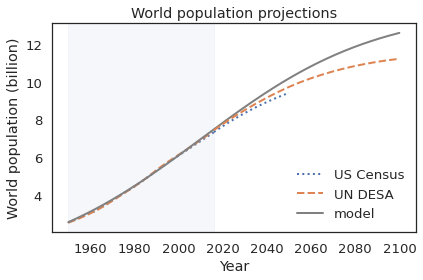

In [ ]:
results = run_simulation(system, update_func_quad)

plt.axvspan(1950, 2016, color='C0', alpha=0.05)
plot_results(census, un, results, 'World population projections')
plot_projections(table3)

People who know what they are doing expect the growth rate to decline more sharply than our model projects.

## Exercises

**Exercise:** The net growth rate of world population has been declining for several decades.  That observation suggests one more way to generate projections, by extrapolating observed changes in growth rate.

The `modsim` library provides a function, `compute_rel_diff`, that computes relative differences of the elements in a sequence.

Here's how we can use it to compute the relative differences in the `census` and `un` estimates:

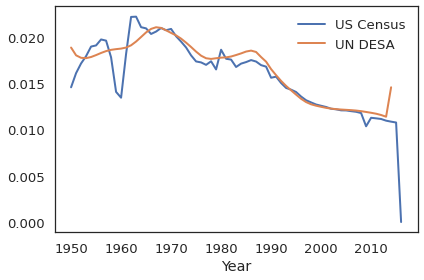

In [ ]:
alpha_census = compute_rel_diff(census)
plot(alpha_census, label='US Census')

alpha_un = compute_rel_diff(un)
plot(alpha_un, label='UN DESA')

decorate(xlabel='Year', label='Net growth rate')

Other than a bump around 1990, net growth rate has been declining roughly linearly since 1965.  As an exercise, you can use this data to make a projection of world population until 2100.

1. Define a function, `alpha_func`, that takes `t` as a parameter and returns an estimate of the net growth rate at time `t`, based on a linear function `alpha = intercept + slope * t`.  Choose values of `slope` and `intercept` to fit the observed net growth rates since 1965.

2. Call your function with a range of `ts` from 1960 to 2020 and plot the results.

3. Create a `System` object that includes `alpha_func` as a system variable.

4. Define an update function that uses `alpha_func` to compute the net growth rate at the given time `t`.

5. Test your update function with `t_0 = 1960` and `p_0 = census[t_0]`.

6. Run a simulation from 1960 to 2100 with your update function, and plot the results.

7. Compare your projections with those from the US Census and UN.

In [ ]:

def alpha_func(t, m, b):
    return m*t + b

<br><font color="purple">As a learning exercise...use linear regression</font><br>

In [ ]:
from sklearn import  linear_model
regr = linear_model.LinearRegression()
alpha_un2=alpha_un[~np.isnan(alpha_un)]
yrs=alpha_un2.keys()
pps=alpha_un2.values
yrs2=yrs.to_numpy()
yrs3=yrs2.reshape(-1,1) 
regr.fit(yrs3, pps)
m=regr.coef_
b=regr.intercept_

print("Slope = ", round(m,6), " Intercept = ", round(b,4))

Slope =  [-0.000139]  Intercept =  0.2922


In [ ]:
results = TimeSeries()

for index, value in alpha_un2.loc[1960:2020].items():
        results[index] = alpha_func(index, m,b)
        

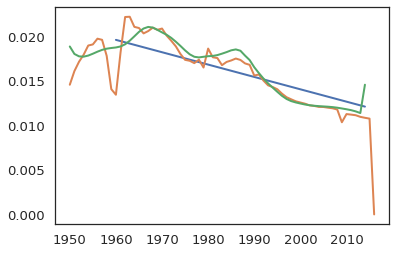

In [ ]:
plot(results, label='Regression Line') 
plot(alpha_census)
plot(alpha_un)    

In [ ]:


# compute the net growth rate at the given time t.
def compute_net_growth(pop, t_end, l_func, m, b):
    return pop * (1 + l_func(t_end,m,b))
    



In [ ]:


system = System(t_0=t_0, t_end=2050, p_0=20, f=alpha_func )

net_growth=compute_net_growth(census[t_0], 1960, system.f, m, b)

print("Net growth = ", net_growth)

Net growth =  [2.60784831]


/usr/local/lib/python3.7/dist-packages/modsim/modsim.py:203: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(t)


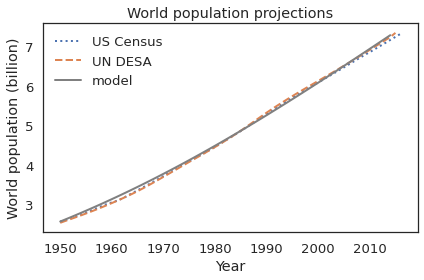

In [ ]:

net_growth = TimeSeries()
net_growth[1950]=p_0

for index, value in alpha_un.loc[1950:2013].items():
        this_year=index
        next_year=index+1
        net_growth[next_year]=compute_net_growth(net_growth[this_year], next_year, system.f, m, b)
        
        
plot_results(census, un, net_growth, 'World population projections')
     

**Related viewing:** You might be interested in this [video by Hans Rosling about the demographic changes we expect in this century](https://www.youtube.com/watch?v=ezVk1ahRF78).